# 📓 OCSVM - 2F - Validación por Repetición
# Basado en nº de outliers

**Proyecto**: Detección de posibles fuentes de materia oscura usando ML en datos Fermi-LAT  
**Autor**: Marta Canino Romero  
**Fecha**: mayo 2025

---

## ✨ Descripción:

Este notebook implementa un modelo **One-Class SVM** entrenado con datos de fuentes astrofísicas conocidas (ASTRO) usando las siguientes características:

- E_peak
- beta

**A diferencia de otros notebooks, aquí el proceso se repite múltiples veces (con diferentes semillas aleatorias en los splits) para comprobar la robustez y variabilidad del modelo.** Cada iteración realiza:

1. División de datos (train/val/test)
2. Escalado
3. Búsqueda de hiperparámetros (grid search sobre `nu` y `gamma`)
4. Evaluación sobre validación y prueba
5. Registro de métricas clave (f1-score, número de outliers, matriz de confusión)

Los resultados de cada iteración se almacenan y analizan para estimar la estabilidad del modelo.

---

## 📌 Objetivos específicos:

- Evaluar la variabilidad del modelo OCSVM tras `N` repeticiones
- Analizar la dispersión del mejor f1-score entre repeticiones
- Comparar número de anomalías detectadas en cada iteración
- Obtener métricas medias y desviaciones estándar

---

## 🗂️ Entrada de datos:

- `../../data/processed/XY_bal_log_Rel/astro/XY_bal_log_Rel_astro.txt`

## 💾 Salida esperada:

- Tabla resumen de métricas por iteración
- Mejor combinación de hiperparámetros promedio
- Exportación de anomalías más recurrentes


In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score, classification_report, confusion_matrix


In [180]:
# Load dataset
# data_path = "../../data/processed/XY_bal_log_Rel/astro/XY_bal_log_Rel_astro.txt"
data_path = "../../data/processed/XY_bal_log_Rel/astro/astro_df.txt"
df_astro = pd.read_csv(data_path, sep='\s+')

df_astro = df_astro.rename(columns={"0,1=astro,DM": "class"})
print(df_astro.columns)

df_astro.head()

Index(['Log(E_peak)', 'Log(beta)', 'Log(sigma)', 'Log(beta_Rel)', 'astro_DM'], dtype='object')


,Log(E_peak),Log(beta),Log(sigma),Log(beta_Rel),astro_DM
0,-0.412502,-1.325139,1.356951,-0.122193,0.0
1,0.708140,-0.000174,0.623167,-1.601886,0.0
2,0.224740,-0.581202,1.010041,-0.311249,0.0
3,0.257319,-0.561933,0.615413,-0.038913,0.0
4,0.326110,-1.100179,1.624932,-0.528753,0.0


In [181]:
# --- Selección de características ---
features = ['Log(E_peak)', 'Log(beta)']
target = 'astro_DM'

print(f"Features seleccionadas: {features}")
print(f"Columna objetivo: {target}")

# --- Comprobamos valores nulos ---
print("\n Valores faltantes por columna:")
print(df_astro[features + [target]].isnull().sum())

print("\n Muestra del dataset:")
display(df_astro[features + [target]].head())

Features seleccionadas: ['Log(E_peak)', 'Log(beta)']
Columna objetivo: astro_DM

 Valores faltantes por columna:
Log(E_peak)    0
Log(beta)      0
astro_DM       0
dtype: int64

 Muestra del dataset:


,Log(E_peak),Log(beta),astro_DM
0,-0.412502,-1.325139,0.0
1,0.708140,-0.000174,0.0
2,0.224740,-0.581202,0.0
3,0.257319,-0.561933,0.0
4,0.326110,-1.100179,0.0


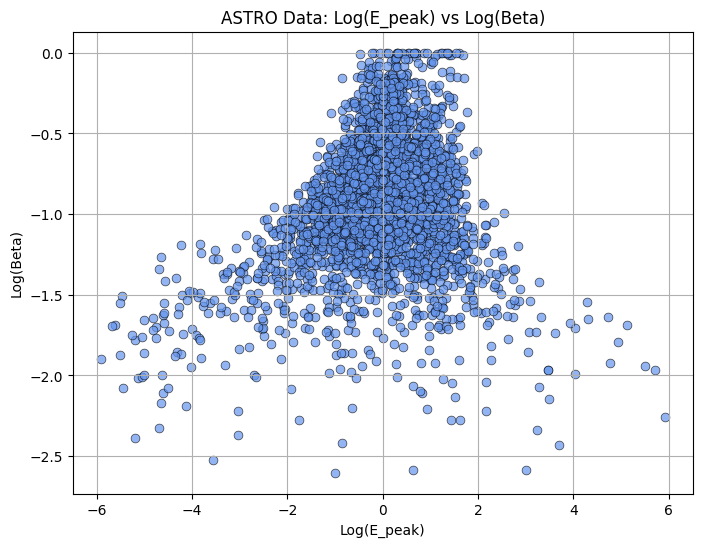

In [182]:
# Comprobamos la distribución de los datos astro antes de escalar
plt.figure(figsize=(8, 6))

sns.scatterplot(
    data=df_astro,
    x="Log(E_peak)",
    y="Log(beta)",
    color="cornflowerblue",  # "skyblue" "cornflowerblue"
    edgecolor='k',
    alpha=0.7,
    s=40
)

plt.title("ASTRO Data: Log(E_peak) vs Log(Beta)")
plt.xlabel("Log(E_peak)")
plt.ylabel("Log(Beta)")
plt.grid(True)
plt.show()

In [183]:

# 💥 Número de repeticiones
n_iterations = 5

# Guardar resultados de todas las iteraciones
all_iterations_results = []
best_models = []  # opcional: guardar modelo por iteración

print("🔍 Buscando hiperparámetros que minimicen outliers en ASTRO (validación)...")
for i in range(n_iterations):
    print(f"\n🔄 Iteración {i+1}/{n_iterations}")

    # =============== 1️⃣ Split dinámico por iteración ===============
    X = df_astro[features].values
    y = df_astro[target].values

    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.4, stratify=y, random_state=42 + i
    )

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=99 + i
    )

    # =============== 2️⃣ Escalado ===============
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # =============== 3️⃣ Grid search en esta iteración ===============
    nu_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05]
    gamma_values = ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10]

    best_score = 0.0
    iteration_results = []
    best_outliers = np.inf
    best_model_iter = None
    best_params_iter = {}

    for nu in nu_values:
        for gamma in gamma_values:
            model = OneClassSVM(kernel='rbf', nu=nu, gamma=gamma)
            model.fit(X_train_scaled)

            preds = model.predict(X_val_scaled)
            pred_labels = np.where(preds == 1, 0, 1)  # 1→normal, -1→outlier
            n_outliers = np.sum(preds == -1)
            true_labels = y_val.astype(int)

            # f1 = f1_score(true_labels, pred_labels, pos_label=0)

            iteration_results.append({'nu': nu, 'gamma': gamma, 'val_outliers': n_outliers})

            """
            if f1 > best_score:
                best_score = f1
                best_model_iter = model
                best_params_iter = {'nu': nu, 'gamma': gamma}
            """
            if n_outliers < best_outliers:
                best_outliers = n_outliers
                best_model_iter = model
                best_params_iter = {'nu': nu, 'gamma': gamma}

    print(f"✅ Mejor iteración {i+1}: nu={best_params_iter['nu']}, gamma={best_params_iter['gamma']}, Outliers (val set): {best_outliers} de {len(X_val_scaled)} muestras")

    # Guardar resultados de esta iteración
    all_iterations_results.extend(
        [dict(iter=i+1, **res) for res in iteration_results]
    )

    best_models.append(best_model_iter)  # opcional

# onvertimos a DataFrame global
df_all_results = pd.DataFrame(all_iterations_results)

# Mostrar el top global
display(df_all_results.sort_values(by='val_outliers', ascending=True))


🔍 Buscando hiperparámetros que minimicen outliers en ASTRO (validación)...

🔄 Iteración 1/5
✅ Mejor iteración 1: nu=0.001, gamma=0.001, Outliers (val set): 1 de 566 muestras

🔄 Iteración 2/5
✅ Mejor iteración 2: nu=0.001, gamma=0.001, Outliers (val set): 2 de 566 muestras

🔄 Iteración 3/5
✅ Mejor iteración 3: nu=0.001, gamma=0.001, Outliers (val set): 1 de 566 muestras

🔄 Iteración 4/5
✅ Mejor iteración 4: nu=0.001, gamma=0.001, Outliers (val set): 5 de 566 muestras

🔄 Iteración 5/5
✅ Mejor iteración 5: nu=0.001, gamma=0.001, Outliers (val set): 0 de 566 muestras


,iter,nu,gamma,val_outliers
185,5,0.005,0.01,0
171,5,0.001,0.01,0
178,5,0.002,0.01,0
170,5,0.001,0.001,0
177,5,0.002,0.001,0
...,...,...,...,...
132,4,0.001,10,264
181,5,0.002,10,264
48,2,0.001,10,271
97,3,0.002,10,272


In [184]:
from sklearn.utils.multiclass import unique_labels

# Paso 1: identificar hiperparámetros globales
best_global = df_all_results.sort_values(by='val_outliers', ascending=True).iloc[0]
print("Mejor combinación global:")
print(best_global)

# Paso 2: reentrenar con X_train + X_val
X_final_train = np.vstack([X_train, X_val])
y_final_train = np.concatenate([y_train, y_val])

scaler_final = StandardScaler()
X_final_train_scaled = scaler_final.fit_transform(X_final_train)
X_test_scaled = scaler_final.transform(X_test)

# Paso 3: entrenar modelo final
final_model = OneClassSVM(kernel='rbf', nu=best_global['nu'], gamma=best_global['gamma'])
final_model.fit(X_final_train_scaled)

# Paso 4: evaluar en test
test_preds = final_model.predict(X_test_scaled)
test_labels = np.where(test_preds == 1, 0, 1)

# Paso 5: métricas
print("\nEvaluación en el conjunto de test:")
print(f"Outliers (test set): {np.sum(test_preds == -1)} de {len(X_test_scaled)} muestras")
# print(f"F1 Score: {f1_score(y_test, test_labels, pos_label=0):.4f}")
print("\nMatriz de confusión:")
cm = confusion_matrix(y_test, test_labels)
print(cm)
print("\nReporte de clasificación:")
print(classification_report(y_test, test_labels, target_names=unique_labels(y_test, test_labels).astype(str)))

Mejor combinación global:
iter                5
nu              0.005
gamma            0.01
val_outliers        0
Name: 185, dtype: object

Evaluación en el conjunto de test:
Outliers (test set): 3 de 567 muestras

Matriz de confusión:
[[564   3]
 [  0   0]]

Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       567
         1.0       0.00      0.00      0.00         0

    accuracy                           0.99       567
   macro avg       0.50      0.50      0.50       567
weighted avg       1.00      0.99      1.00       567



/Users/martacaninoromero/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/martacaninoromero/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/martacaninoromero/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

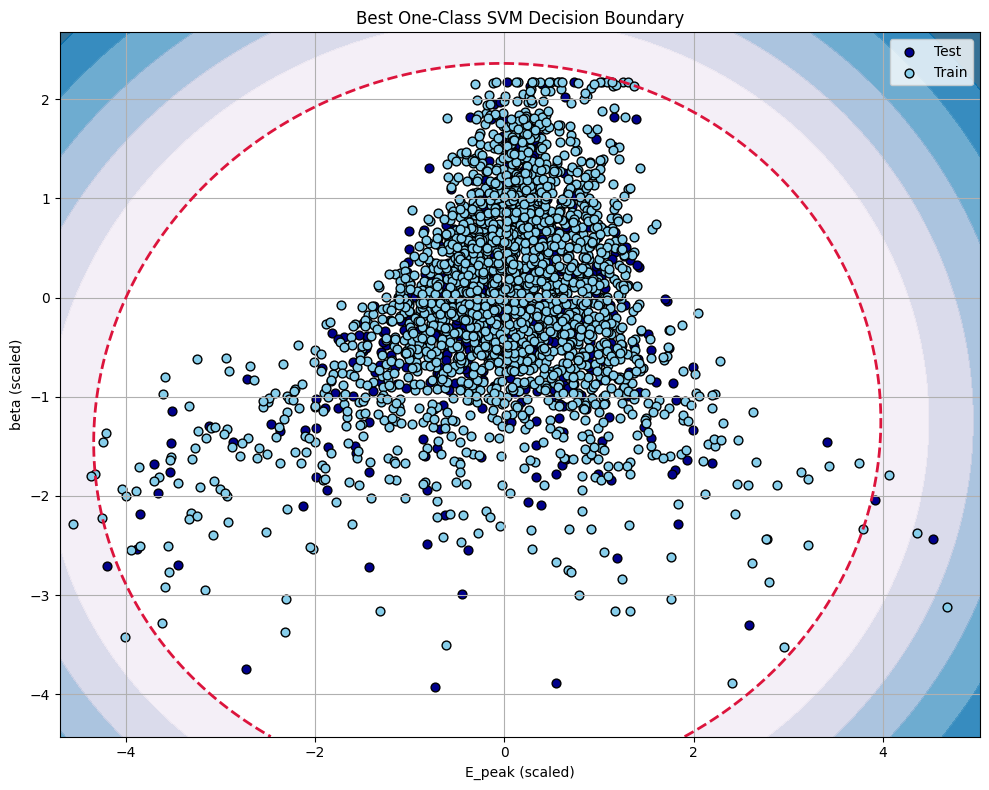

In [185]:
# Create meshgrid (with correct feature order)
xx, yy = np.meshgrid(
    np.linspace(X_test_scaled[:, 0].min() - 0.5, X_test_scaled[:, 0].max() + 0.5, 300),  # E_peak
    np.linspace(X_test_scaled[:, 1].min() - 0.5, X_test_scaled[:, 1].max() + 0.5, 300)   # beta
)

grid = np.c_[xx.ravel(), yy.ravel()]

Z = final_model.decision_function(grid)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu_r, alpha=0.8)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='crimson', linestyles='--')

# Plot training and test data
plt.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], c='darkblue', edgecolors='k', s=40, label='Test')
plt.scatter(X_final_train_scaled[:, 0], X_final_train_scaled[:, 1], c='skyblue', edgecolors='k', s=40, label='Train')

plt.xlabel("E_peak (scaled)")
plt.ylabel("beta (scaled)")
plt.title("Best One-Class SVM Decision Boundary")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Predict on UNIDs

In [186]:
# unids_path = "../../data/raw/unids_3F_beta_err_names.txt"
unids_path = "../../data/processed/unids_log/unids_log.txt"
df_unids = pd.read_csv(unids_path, sep='\s+')
df_unids.head()

,Log(E_peak),Log(beta),Log(sigma_det),Log(beta_Rel),number
0,0.400175,-1.047208,0.869208,0.212452,0
1,0.169733,-0.380594,0.733598,-0.113037,1
2,0.203142,-0.168578,1.033058,-0.430366,2
3,-0.031074,-0.557363,0.881133,-0.201588,3
4,-0.351835,-0.493901,0.630916,-0.246028,4


In [187]:
# Extraer y escalar
X_unids_log = df_unids[["Log(E_peak)", "Log(beta)"]].values
X_unids_scaled = scaler.transform(X_unids_log)

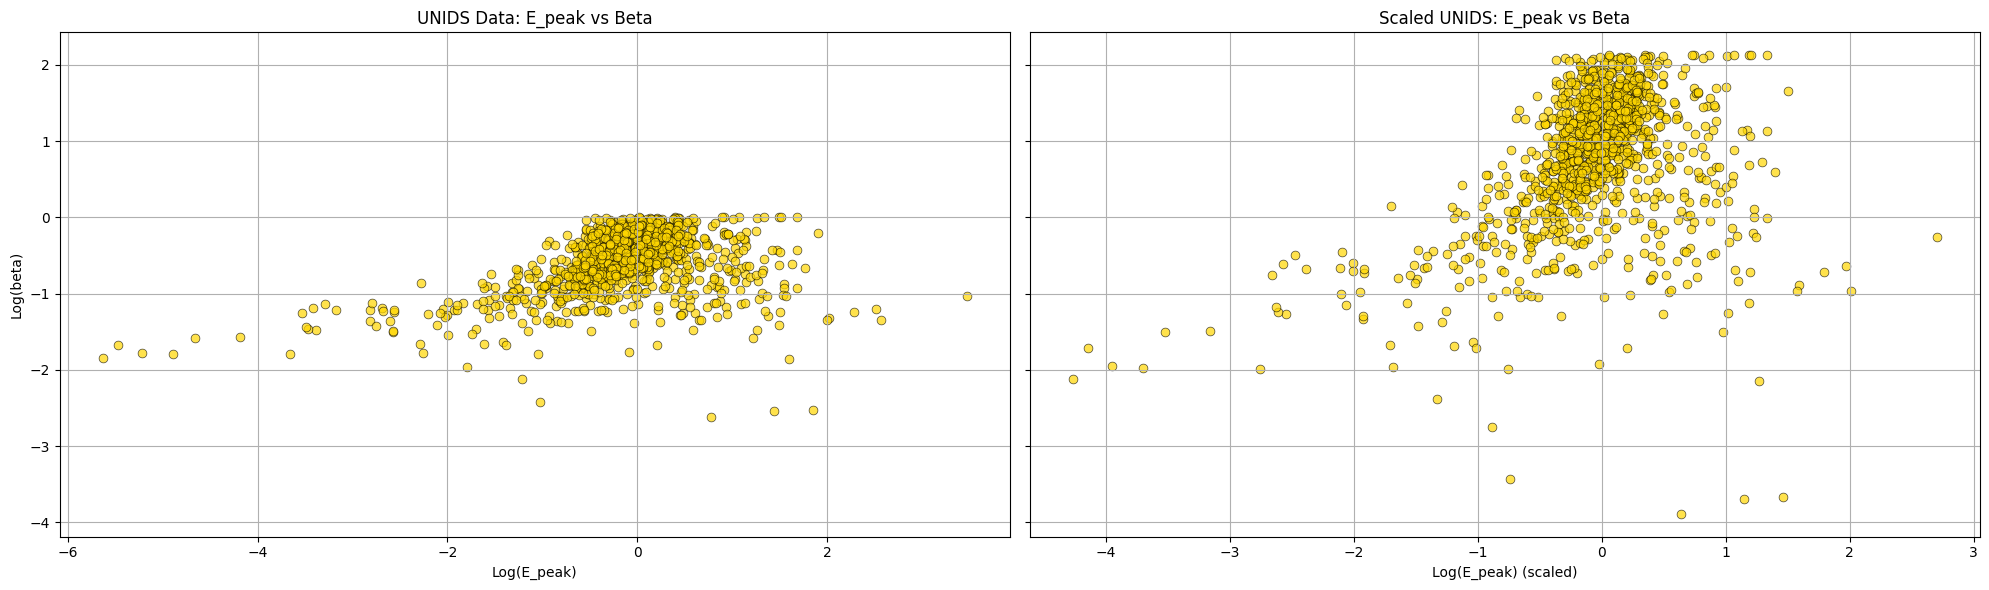

In [188]:
# --- Create subplots ---
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

# --- Plot 1: Raw UNIDS data ---
sns.scatterplot(
    data=df_unids,
    x="Log(E_peak)",
    y="Log(beta)",
    color="gold",
    edgecolor='k',
    alpha=0.7,
    s=40,
    ax=axes[0]
)
axes[0].set_title("UNIDS Data: E_peak vs Beta")
axes[0].set_xlabel("Log(E_peak)")
axes[0].set_ylabel("Log(beta)")
axes[0].grid(True)

# --- Plot 3: Scaled UNIDS ---
sns.scatterplot(
    x=X_unids_scaled[:, 0],
    y=X_unids_scaled[:, 1],
    color="gold",
    edgecolor='k',
    alpha=0.7,
    s=40,
    ax=axes[1]
)
axes[1].set_title("Scaled UNIDS: E_peak vs Beta")
axes[1].set_xlabel("Log(E_peak) (scaled)")
axes[1].set_ylabel("Log(beta) (scaled)")
axes[1].grid(True)

plt.tight_layout()
plt.show()


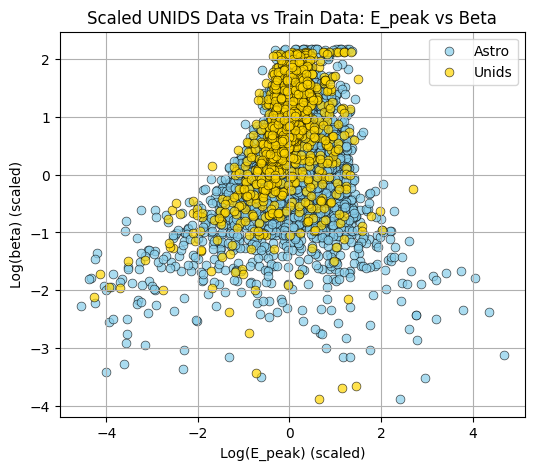

In [189]:
# Scatter de unids escalados vs datos de entrenamiento escalados
plt.figure(figsize=(6, 5))
sns.scatterplot(
    x=X_final_train_scaled[:, 0],
    y=X_final_train_scaled[:, 1],
    color="skyblue",  # "skyblue" "cornflowerblue"
    edgecolor='k',
    alpha=0.7,
    s=40,
    label='Astro'
)
sns.scatterplot(
    x=X_unids_scaled[:, 0],
    y=X_unids_scaled[:, 1],
    color="gold",  # "skyblue" "cornflowerblue"
    edgecolor='k',
    alpha=0.7,
    s=40,
    label='Unids'
)
plt.title("Scaled UNIDS Data vs Train Data: E_peak vs Beta")
plt.xlabel("Log(E_peak) (scaled)")
plt.ylabel("Log(beta) (scaled)")
plt.legend()
plt.grid(True)
plt.show()

In [190]:
# Predecir con el modelo final
unids_preds = final_model.predict(X_unids_scaled)
unids_labels = np.where(unids_preds == 1, 0, 1)  # 1→normal, -1→outlier

n_outliers = np.sum(unids_preds == -1)
n_normals = np.sum(unids_preds == 1)

print(f"Predicted ASTRO-like: {n_normals}")
print(f"Predicted not ASTRO-like (anomalies): {n_outliers}")

# Añadir etiquetas al DataFrame
df_unids['pred_labels'] = unids_labels

# Filtrar los datos no clasificados
df_unids['pred_labels'] = df_unids['pred_labels'].astype(int)
df_unids['pred_labels'] = df_unids['pred_labels'].replace({0: 'Normal', 1: 'Anomalía'})


Predicted ASTRO-like: 1125
Predicted not ASTRO-like (anomalies): 0


In [191]:
df_unids.head()

,Log(E_peak),Log(beta),Log(sigma_det),Log(beta_Rel),number,pred_labels
0,0.400175,-1.047208,0.869208,0.212452,0,Normal
1,0.169733,-0.380594,0.733598,-0.113037,1,Normal
2,0.203142,-0.168578,1.033058,-0.430366,2,Normal
3,-0.031074,-0.557363,0.881133,-0.201588,3,Normal
4,-0.351835,-0.493901,0.630916,-0.246028,4,Normal


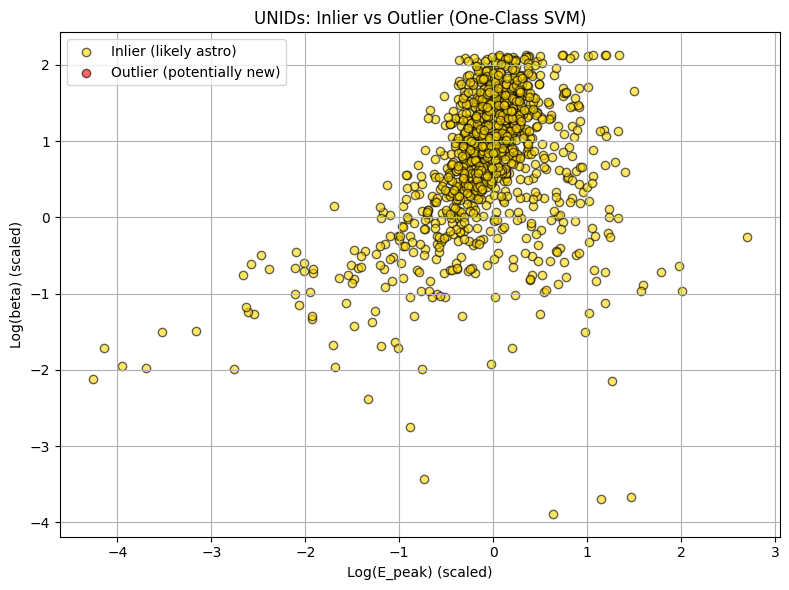

In [192]:
inliers = X_unids_scaled[unids_preds == 1]
outliers = X_unids_scaled[unids_preds == -1]

plt.figure(figsize=(8, 6))

plt.scatter(inliers[:, 0], inliers[:, 1], c='gold', edgecolors='k', label='Inlier (likely astro)', alpha=0.6)
plt.scatter(outliers[:, 0], outliers[:, 1], c='red', edgecolors='k', label='Outlier (potentially new)', alpha=0.6)

plt.xlabel("Log(E_peak) (scaled)")
plt.ylabel("Log(beta) (scaled)")

plt.title("UNIDs: Inlier vs Outlier (One-Class SVM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

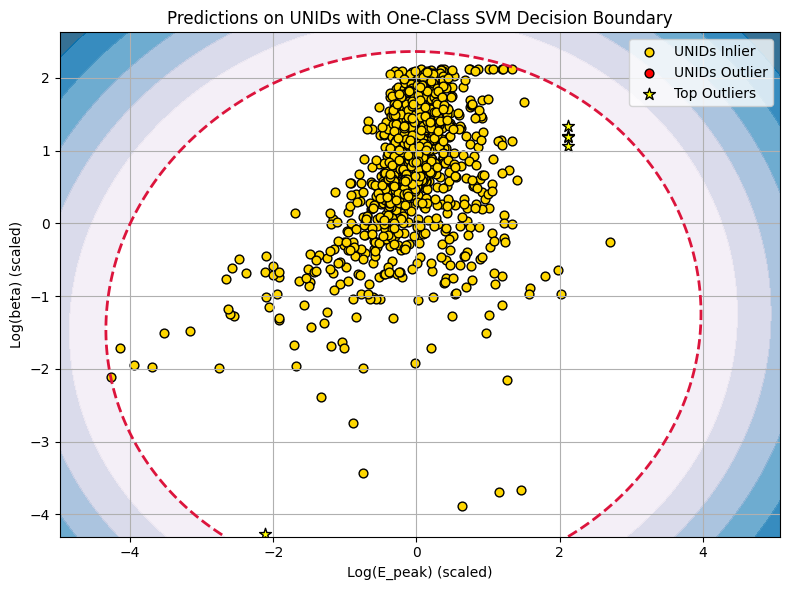

In [193]:
# Create meshgrid (with correct feature order: [beta, E_peak])
xx, yy = np.meshgrid(
    np.linspace(X_train_scaled[:, 0].min() - 0.5, X_train_scaled[:, 0].max() + 0.5, 300),  # E_peak
    np.linspace(X_train_scaled[:, 1].min() - 0.5, X_train_scaled[:, 1].max() + 0.5, 300)   # beta
)

grid = np.c_[xx.ravel(), yy.ravel()]  # correcto orden

Z = final_model.decision_function(grid)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu_r, alpha=0.8)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='crimson', linestyles='--')

preds_unids = final_model.predict(X_unids_scaled)
inliers = X_unids_scaled[preds_unids == 1]
outliers = X_unids_scaled[preds_unids == -1]

plt.scatter(inliers[:, 0], inliers[:, 1], c='gold', edgecolors='k', s=40, label='UNIDs Inlier')
plt.scatter(outliers[:, 0], outliers[:, 1], c='red', edgecolors='k', s=40, label='UNIDs Outlier')

# Highlight most anomalous UNIDs using their lowest decision score:
decision_scores = final_model.decision_function(X_unids_scaled)
# Optional: mark top 5 most anomalous
top_anomalies = X_unids_scaled[np.argsort(decision_scores)[:5]]
plt.scatter(top_anomalies[:, 1], top_anomalies[:, 0], c='yellow', edgecolors='black', s=80, label='Top Outliers', marker='*')


plt.xlabel("Log(E_peak) (scaled)")
plt.ylabel("Log(beta) (scaled)")
plt.title("Predictions on UNIDs with One-Class SVM Decision Boundary")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Anomaly Scoring - UNIDs

In [194]:
# Paso 1: Evaluar cada muestra no identificada con el modelo entrenado
# decision_function devuelve un valor continuo: cuanto más alto, más normal (positivo); cuanto más bajo, más anómalo (negativo)
decision_scores = final_model.decision_function(X_unids_scaled)  # X_unids_scaled = muestras no etiquetadas, ya escaladas

# Paso 2: Predecir si cada punto es inlier (1) o outlier (-1)
unids_preds = final_model.predict(X_unids_scaled)  # 1 = normal, -1 = anomalía

# Paso 3: Agregar los resultados al DataFrame original
df_unids["svm_score"] = decision_scores       # Puntaje bruto del modelo (positivo = normal)
df_unids["prediction"] = unids_preds          # Clasificación binaria: inlier o outlier

# Paso 4: Invertimos el score para que valores más altos signifiquen más anomalía
# Esto es útil para poder escalar la puntuación y ordenar más intuitivamente
anom_scores = -decision_scores  # Ahora, valores grandes = más anómalos

# Paso 5: Escalamos los scores de anomalía al rango [0, 100] para facilitar su interpretación
anom_percent = MinMaxScaler(feature_range=(0, 100)).fit_transform(anom_scores.reshape(-1, 1)).flatten()

# Guardamos el puntaje invertido y su porcentaje normalizado en el DataFrame
df_unids["Anomaly_Score"] = anom_scores
df_unids["Anomaly_Rank(%)"] = anom_percent  # 100 = más anómalo, 0 = más normal

# Paso 6: Filtramos solo los puntos predichos como anómalos y los ordenamos por su score más alto
top_anomalies = df_unids[df_unids["prediction"] == -1] \
                    .sort_values(by="Anomaly_Rank(%)", ascending=False) \
                    .head(10)

# Guardamos los índices (puede ser útil si queremos recuperar sus posiciones originales)
most_anomalous_idx = top_anomalies.index

# Paso 7: Guardamos los 10 más anómalos en un archivo
# top_anomalies.to_csv("../../data/processed/unids_most_anomalous.txt", sep="\t", index=False)

# Paso 8: Mostramos en pantalla un resumen de las anomalías detectadas
print("Top Most Anomalous UNID Sources (4F One-Class SVM):")
display(top_anomalies[['Log(E_peak)', 'Log(beta)', 'number', 'svm_score', 'Anomaly_Score', 'Anomaly_Rank(%)']])

Top Most Anomalous UNID Sources (4F One-Class SVM):


,Log(E_peak),Log(beta),number,svm_score,Anomaly_Score,Anomaly_Rank(%)


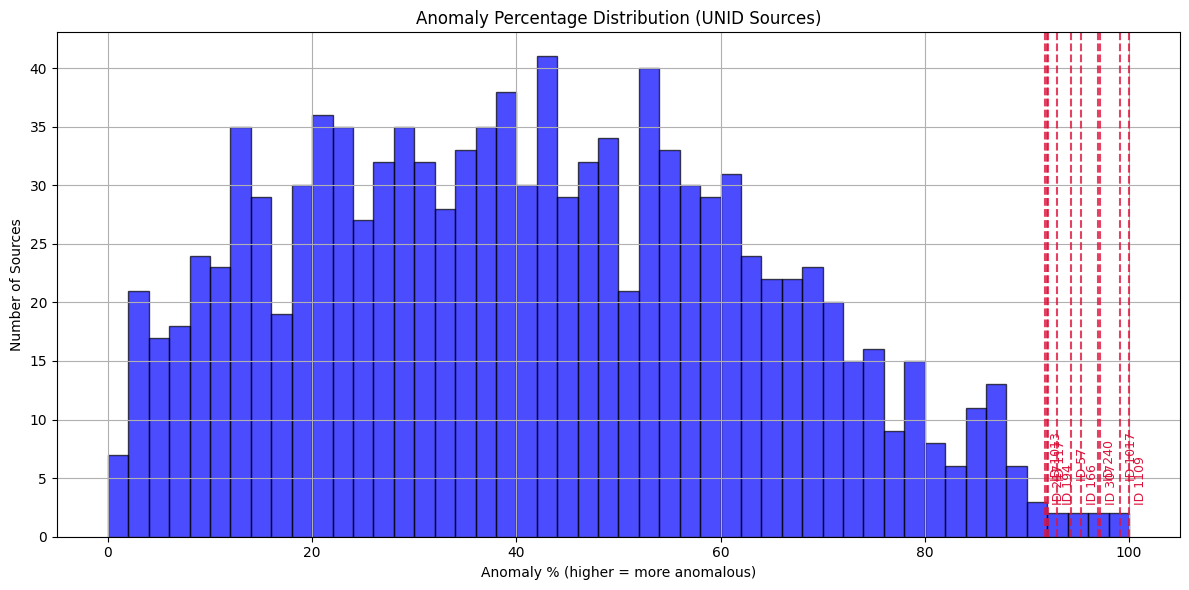

In [195]:
# Sort anomaly scores and grab top N labels
N = 10
sorted_idx = np.argsort(-anom_percent)  # high anomaly % = more anomalous
top_N_idx = sorted_idx[:N]

top_labels = df_unids.iloc[top_N_idx]['number'].astype(str).values
top_scores = anom_percent[top_N_idx]

plt.figure(figsize=(12, 6))
plt.hist(anom_percent, bins=50, color='blue', edgecolor='k', alpha=0.7)
plt.title("Anomaly Percentage Distribution (UNID Sources)")
plt.xlabel("Anomaly % (higher = more anomalous)")
plt.ylabel("Number of Sources")

for i in range(N):
    x = top_scores[i]
    label = top_labels[i]
    plt.axvline(x, color='crimson', linestyle='--', alpha=0.8)
    plt.text(x + 0.5, 3 + (i % 2) * 2, f"ID {label}", rotation=90, color='crimson', ha='left', fontsize=9)

plt.grid(True)
plt.tight_layout()
plt.show()


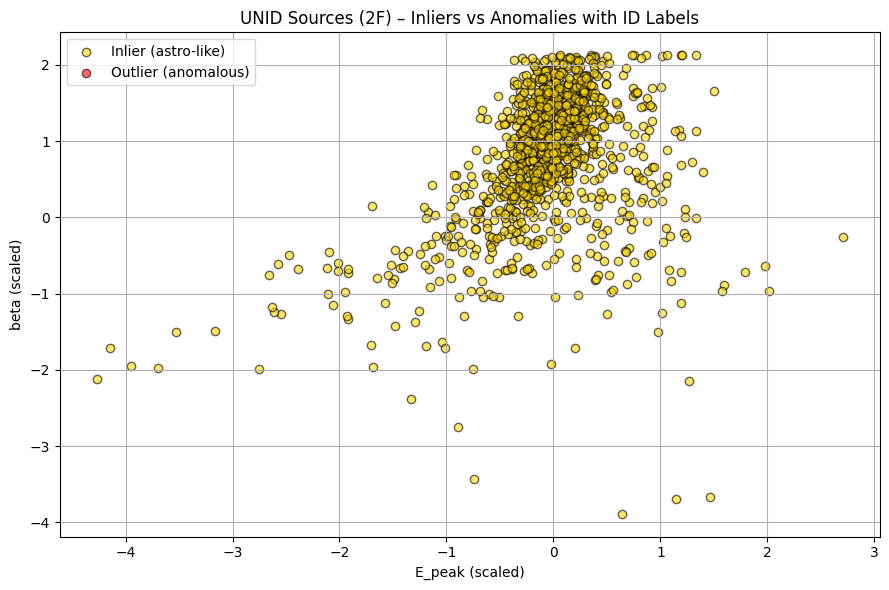

In [196]:
plt.figure(figsize=(9, 6))

# Inliers and outliers from scaled data
inliers = X_unids_scaled[unids_preds == 1]
outliers = X_unids_scaled[unids_preds == -1]

# Plot inliers (gold)
plt.scatter(inliers[:, 0], inliers[:, 1], c='gold', edgecolors='k', label='Inlier (astro-like)', alpha=0.6)

# Plot outliers (red)
plt.scatter(outliers[:, 0], outliers[:, 1], c='red', edgecolors='k', label='Outlier (anomalous)', alpha=0.6)

# Annotate top 10 anomalies by ID
for idx in most_anomalous_idx:
    x = X_unids_scaled[idx, 0]  # E_peak (scaled)
    y = X_unids_scaled[idx, 1]  # beta (scaled)
    label = int(df_unids.loc[idx, 'number'])
    plt.text(x + 0.1, y, str(label), color='black', fontsize=9)

# Axis labels and styling
plt.xlabel("E_peak (scaled)")
plt.ylabel("beta (scaled)")
plt.title("UNID Sources (2F) – Inliers vs Anomalies with ID Labels")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("../../outputs/figures/scaled/2F_UNIDs_OneClassSVM_2D_scaled.png", dpi=300, bbox_inches='tight')

plt.show()


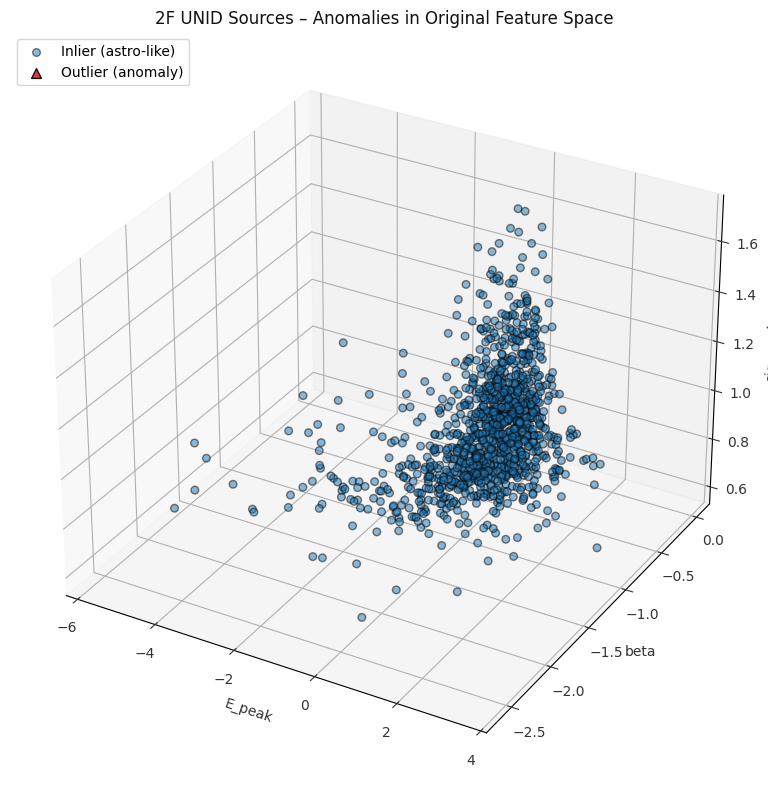

In [197]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Original/log-transformed values for 3 relevant features
x_vals = df_unids['Log(E_peak)'].values
y_vals = df_unids['Log(beta)'].values
z_vals = df_unids['Log(sigma_det)'].values  # or 'beta_Rel' for 3F.2

# Use model predictions for coloring
inlier_idx = df_unids['prediction'] == 1
outlier_idx = df_unids['prediction'] == -1

# Inliers
ax.scatter(
    x_vals[inlier_idx], y_vals[inlier_idx], z_vals[inlier_idx],
    c='#1f77b4', edgecolor='k', s=30, label='Inlier (astro-like)', alpha=0.5
)

# Outliers
ax.scatter(
    x_vals[outlier_idx], y_vals[outlier_idx], z_vals[outlier_idx],
    c='#d62728', marker='^', edgecolor='k', s=50, label='Outlier (anomaly)', alpha=0.9
)

# Annotate top anomalies
top_anomalies = df_unids[df_unids['prediction'] == -1].sort_values('Anomaly_Rank(%)', ascending=False).head(10)
for idx in top_anomalies.index:
    ax.scatter(
        x_vals[idx], y_vals[idx], z_vals[idx],
        facecolors='none', edgecolors='black', linewidths=2, s=100
    )
    ax.text(
        x_vals[idx], y_vals[idx], z_vals[idx] + 0.05,
        str(int(df_unids.loc[idx, 'number'])),
        color='black', fontsize=9
    )

ax.set_xlabel('E_peak')
ax.set_ylabel('beta')
ax.set_zlabel('sigma_det')  # or 'beta_Rel'
ax.set_title("2F UNID Sources – Anomalies in Original Feature Space")
ax.legend(loc='upper left')

ax.tick_params(colors='#333333')
ax.xaxis.label.set_color('#333333')
ax.yaxis.label.set_color('#333333')
ax.zaxis.label.set_color('#333333')
ax.title.set_color('#111111')
ax.grid(color='#aaaaaa', linestyle='--', alpha=0.3)

plt.savefig("../../outputs/figures/2F_UNIDs_OneClassSVM_og.png", dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

# Comparar con UNIDs ANN

In [198]:

# Load unID source data
# unids_path = "../../data/raw/unids_3F_beta_err_names.txt"
unids_3F = np.genfromtxt('../../data/raw/unids_3F_beta_err_names.txt',dtype='str') 
unids_3F_data = np.asarray(unids_3F[1::,:],dtype=float)
unids_log=np.log10(unids_3F_data[:,[0,1]])

# Load unid data with DM proba
ann_unids_path = "../../ANN_original/unids_DM_std_proba_check_repeated_kfold_2F_21.txt"
unids_DM_std_proba_repeated_kfold = np.genfromtxt(ann_unids_path, dtype='str')
print(unids_DM_std_proba_repeated_kfold[0:3])

[['Numb' 'unids_DM_proba_check_repeated_kfold']
 ['0' '4.410883601199984e-11']
 ['1' '0.5128374525851896']]


In [199]:

unids_DM_std_proba_data_repeated_kfold = np.asarray(unids_DM_std_proba_repeated_kfold[1:], dtype=float)

N_unids=unids_log.shape[0]
N_splits = 5
N_Repeats = 2
N_sample = N_splits * N_Repeats

unids_number = unids_DM_std_proba_data_repeated_kfold[0:N_unids, 0]

unids_DM_std_proba_N_sample_repeated_kfold = np.zeros((N_unids, N_sample + 1))
unids_DM_std_proba_N_sample_repeated_kfold[:, 0] = unids_number.astype(int)
unids_DM_std_proba_N_sample_repeated_kfold[:, 1:(N_sample+1)] = np.reshape(
    unids_DM_std_proba_data_repeated_kfold[:, 1], (N_unids, N_sample))

unids_mean = unids_DM_std_proba_N_sample_repeated_kfold[:, 1:(N_sample+1)].mean(axis=1)
unids_std = unids_DM_std_proba_N_sample_repeated_kfold[:, 1:(N_sample+1)].std(axis=1, ddof=1)

df_ann = pd.DataFrame({
    'unid_idx': unids_number.astype(int),
    'ann_mean_prob': unids_mean,
    'ann_std_prob': unids_std
})

df_ann.to_csv('ann_probs_per_unid.csv', index=False)

df_ann.head()


,unid_idx,ann_mean_prob,ann_std_prob
0,0,0.244647,0.265055
1,1,0.185154,0.268088
2,2,0.301971,0.379135
3,3,0.396568,0.290201
4,4,0.352528,0.297019


In [200]:

print('df_unids colummns: ', df_unids.columns)
print('df_ann columns: ', df_ann.columns)

print("Total unIDs ann:", len(df_ann))
print("Total unIDs ocsvm:", len(df_unids))
print("High ANN prob (≥0.9):", (df_ann['ann_mean_prob'] >= 0.9).sum())
print("High ANN prob (≥0.5):", (df_ann['ann_mean_prob'] >= 0.5).sum())

print("Predicted anomalies (OCSVM):", (df_unids['prediction'] == -1).sum())
print("Anomaly rank ≥95%:", (df_unids['Anomaly_Rank(%)'] >= 95).sum())

# Is this true?
set(df_ann['unid_idx']) == set(df_unids['number'].astype(int))

# ensure UNID ID types from both datasets match
df_unids["unid_idx"] = df_unids["number"].astype(int)

# Merge ANN and OCSVM results
df_combined = pd.merge(df_unids, df_ann, on="unid_idx", how="inner")

# Optional: sort by ANN prob or anomaly percent
# df_combined_sorted = df_combined.sort_values(by=["ann_mean_prob", "Anomaly_Rank(%)"], ascending=[False, False])
# another shot: only filter on anomaly, then sort by ANN prob
df_combined[df_combined["Anomaly_Rank(%)"] >= 95].sort_values(by="ann_mean_prob", ascending=False).head(10)


df_unids colummns:  Index(['Log(E_peak)', 'Log(beta)', 'Log(sigma_det)', 'Log(beta_Rel)', 'number',
       'pred_labels', 'svm_score', 'prediction', 'Anomaly_Score',
       'Anomaly_Rank(%)'],
      dtype='object')
df_ann columns:  Index(['unid_idx', 'ann_mean_prob', 'ann_std_prob'], dtype='object')
Total unIDs ann: 1125
Total unIDs ocsvm: 1125
High ANN prob (≥0.9): 0
High ANN prob (≥0.5): 4
Predicted anomalies (OCSVM): 0
Anomaly rank ≥95%: 5


,Log(E_peak),Log(beta),Log(sigma_det),Log(beta_Rel),number,pred_labels,svm_score,prediction,Anomaly_Score,Anomaly_Rank(%),unid_idx,ann_mean_prob,ann_std_prob
307,1.510143,0.000000,0.617263,-3.045757,307,Normal,0.033586,1,-0.033586,97.168125,307,0.357062,0.198370
1109,-5.628028,-1.847712,0.632983,0.838938,1109,Normal,0.002701,1,-0.002701,100.000000,1109,0.347165,0.193565
240,1.493960,-0.000391,0.649860,-1.279450,240,Normal,0.035936,1,-0.035936,96.952615,240,0.333237,0.186204
1017,1.682984,-0.000087,0.632690,-1.191027,1017,Normal,0.012424,1,-0.012424,99.108498,1017,0.311443,0.305182
166,1.329194,0.000000,0.637159,-2.420216,166,Normal,0.053590,1,-0.053590,95.333910,166,0.257563,0.225955


In [201]:
# Define thresholds
p_cut = 0.40
anom_cut = 80

# Filter: high probability and high anomaly
top_candidates = df_combined[
    (df_combined["ann_mean_prob"] >= p_cut) &
    (df_combined["Anomaly_Rank(%)"] >= anom_cut)
]

# Sort by anomaly strength
top_candidates = top_candidates.sort_values(by="Anomaly_Rank(%)", ascending=False).head(10)

# Save or display
# top_candidates.to_csv("../../data/processed/unids_ann_ocsvm_top_combined.csv", index=False)

print("Top UNIDs by ANN and OCSVM agreement:")
display(top_candidates[["unid_idx", "Log(E_peak)", "Log(beta)", "ann_mean_prob", "Anomaly_Rank(%)", "Anomaly_Score"]])

Top UNIDs by ANN and OCSVM agreement:


,unid_idx,Log(E_peak),Log(beta),ann_mean_prob,Anomaly_Rank(%),Anomaly_Score
774,774,0.108633,-0.049635,0.421578,83.105473,-0.186954
802,802,0.052155,-0.050074,0.422792,82.981238,-0.188309


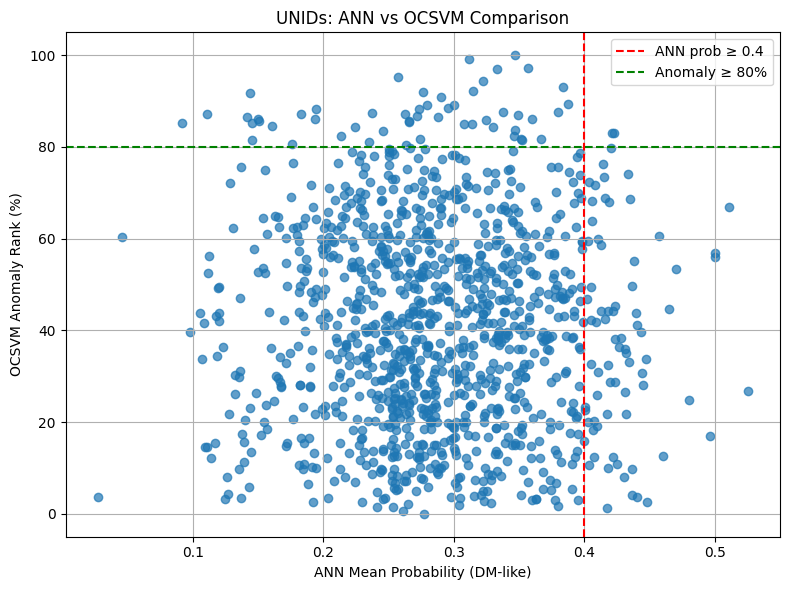

In [202]:
plt.figure(figsize=(8,6))
plt.scatter(df_combined["ann_mean_prob"], df_combined["Anomaly_Rank(%)"], alpha=0.7)
plt.axvline(p_cut, color='r', linestyle='--', label=f"ANN prob ≥ {p_cut}")
plt.axhline(anom_cut, color='g', linestyle='--', label=f"Anomaly ≥ {anom_cut}%")
plt.xlabel("ANN Mean Probability (DM-like)")
plt.ylabel("OCSVM Anomaly Rank (%)")
plt.title("UNIDs: ANN vs OCSVM Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()